# Winning Jeopardy 

## Setup

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import chisquare

In [4]:
%matplotlib inline
sns.set_style('darkgrid')

In [5]:
jeopardy = pd.read_csv('jeopardy.csv')
jeopardy.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [6]:
jeopardy.columns = [ col.strip() for col in jeopardy.columns ]
print('\nCOLUMNS\n')
print(*jeopardy.columns, sep='\n')


COLUMNS

Show Number
Air Date
Round
Category
Value
Question
Answer


## Normalize Columns

### _ Text

In [7]:
def normalize_text(input):
    s = input.lower()
    s = re.sub(r'[^A-Za-z0-9]+', ' ', s)
    s = re.sub(r'\s+', ' ', s)
    return s

In [8]:
jeopardy['clean_question'] = jeopardy['Question'].apply(normalize_text)
jeopardy['clean_answer'] = jeopardy['Answer'].apply(normalize_text)

### _ Currency

In [9]:
jeopardy.Value.str[0].value_counts()

$    19663
N      336
Name: Value, dtype: int64

In [10]:
jeopardy.Value[jeopardy.Value.str[0] == 'N'].value_counts()

None    336
Name: Value, dtype: int64

In [11]:
def normalize_currency(val):
    if val == 'None':
        return 0
    if val[0] == '$':
        num = re.sub(',', '', val[1:])
        return int(num)
    raise 'Unexpected Value'

In [12]:
clean_value = jeopardy.Value.apply(normalize_currency)
clean_value.describe()

count    19999.000000
mean       748.336267
std        653.988299
min          0.000000
25%        400.000000
50%        600.000000
75%       1000.000000
max      12000.000000
Name: Value, dtype: float64

In [13]:
jeopardy['clean_value'] = clean_value

### _ Date

In [14]:
jeopardy['Air Date'] = pd.to_datetime(jeopardy['Air Date'])
jeopardy = jeopardy.set_index('Show Number')

## Analysis

### _ Questions in Answers

In [15]:
def count_qa_matches(row):
    not_the = lambda val: val != 'the'
    split_answer = list(filter(not_the, row.clean_answer.split()))
    
    if len(split_answer) == 0: return 0

    split_question = row.clean_question.split()
    
    match_count = 0
    for word in split_answer:
        if word in split_question:
            match_count += 1
            
    return match_count / len(split_answer)

In [16]:
answer_in_question = jeopardy.apply(count_qa_matches, axis = 1)
answer_in_question.mean()

0.06230943623438248

On average around 6% of the words forming an answer are also part of the question. A winning strategy based on similiarity of question and answer is likely not a very effective one, particularly as we excluded only the word 'the' from the comparison. Assumably there are more words causing wrong/insignificant matches.

### _ Reused Question Terms

In [17]:
jeopardy_sorted_date = jeopardy.sort_values('Air Date')
gte_6_chars = lambda word: len(word) >= 6
terms_used = {}
question_overlap = []

for _, row in jeopardy_sorted_date.iterrows():
    words = list(filter(gte_6_chars, row['clean_question'].split()))
    match_count = 0
    for word in words:
        new_words = {}
        if word in terms_used:
            terms_used[word] += 1
            match_count += 1
        else:
            new_words[word] = 0
    terms_used.update(new_words)
    if len(words) > 0:
        match_count /= len(words)
    question_overlap.append(match_count)

In [18]:
terms_used_series = pd.Series(terms_used)
jeopardy_sorted_date['question_overlap'] = question_overlap
jeopardy = jeopardy.merge(jeopardy_sorted_date)

In [19]:
print('\nMean question overlap: {:.2%}'.format(jeopardy['question_overlap'].mean()))
print('Total terms reused:', terms_used_series.sum())
print('\nTop 20 reused question terms:')
print(terms_used_series.sort_values(ascending=False)[:20])


Mean question overlap: 53.56%
Total terms reused: 47676

Top 20 reused question terms:
archive      1186
target        974
country       572
called        516
played        298
president     285
american      281
capital       263
before        254
became        251
famous        242
french        233
island        225
letter        214
largest       196
people        193
author        191
national      182
little        178
company       172
dtype: int64


... some interpretation ...

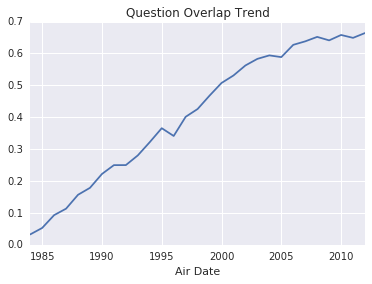

In [20]:
jeopardy.resample('Y', on='Air Date')\
    .mean()['question_overlap']\
    .plot.line(title='Question Overlap Trend');

... some interpretation ...

### _ Identifiying high value questions

In [21]:
high_value = jeopardy.clean_value > 800

def discern_high_value(row):
    return 1 if row.clean_value > 800 else 0

In [22]:
jeopardy['high_value'] = jeopardy.apply(discern_high_value, axis = 1)
jeopardy['high_value'].value_counts()

0    14265
1     5734
Name: high_value, dtype: int64

In [31]:
def low_high_count(word):
    low_count = 0
    high_count = 0
    for idx, row in jeopardy.iterrows():
        q_words = row.clean_question.split()
        if word in q_words:
            if row.high_value:
                high_count += 1
            else:
                low_count += 1
    return low_count, high_count

**Most Reused Terms**

In [97]:
comparison_terms = sorted(terms_used, key=terms_used.get, reverse = True)[:10]
comparison_terms

['archive',
 'target',
 'country',
 'called',
 'played',
 'president',
 'american',
 'capital',
 'before',
 'became']

In [98]:
observed_expected = [ low_high_count(term) for term in comparison_terms ]
observed_expected

[(528, 422),
 (409, 350),
 (414, 158),
 (346, 168),
 (213, 78),
 (203, 76),
 (193, 90),
 (190, 64),
 (191, 71),
 (203, 79)]

In [99]:
high_value_count = len(jeopardy[jeopardy.high_value == 1])
low_value_count = len(jeopardy) - high_value_count
print('High value count:', high_value_count)
print('Low value count:', low_value_count)

High value count: 5734
Low value count: 14265


In [100]:
chi_squared = []

for low_high_counts_word in observed_expected:
    total_prop = sum(low_high_counts_word) / len(jeopardy)
    low_value_expected = total_prop * low_value_count
    high_value_expected = total_prop * high_value_count
    
    observed = low_high_counts_word
    expected = [low_value_expected, high_value_expected]
    chisq, p_value = chisquare(observed, expected)
    chi_squared.append((chisq, p_value))
    
word_chi_p = [[w, terms_used[w], c, p] for w, (c, p) in zip(comparison_terms, chi_squared)]
    
pd.DataFrame(word_chi_p, columns = ['term', 'term_reused', 'chisq', 'p']).sort_values('p')


,term,term_reused,chisq,p
0,archive,1186,115.226086,7.021784e-27
1,target,974,112.905509,2.263070e-26
3,called,516,4.048305,4.421572e-02
7,capital,263,1.499430,2.207591e-01
6,american,281,1.356290,2.441814e-01
4,played,298,0.496150,4.811967e-01
8,before,254,0.316667,5.736178e-01
2,country,572,0.307808,5.790282e-01
5,president,285,0.279477,5.970440e-01
9,became,251,0.059566,8.071837e-01
